# Experiment: DRL vs MVO 再現実装（単一ノートブック）

## 目的
- 論文の枠組み（10本の walk-forward バックテスト）を維持しつつ、短縮学習設定で DRL と MVO を同条件比較する。
- 実装はこの 1 ファイル内で完結させる。

## 完了条件
- DRL / MVO のバックテスト結果が算出される。
- 指標と図が `outputs/reproduction_artifacts/` に保存される。
- 時点整合（`t`で意思決定、`t+1`で収益反映）がコード上で担保される。


In [1]:
import os
import json
import math
import warnings
import functools
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import gymnasium as gym
from gymnasium import spaces

import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv

from sklearn.covariance import LedoitWolf
from pypfopt import EfficientFrontier
import yfinance as yf

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=6)

VERSIONS = {
    'python': os.sys.version.split()[0],
    'numpy': np.__version__,
    'pandas': pd.__version__,
    'torch': torch.__version__,
    'gymnasium': gym.__version__,
    'stable_baselines3': __import__('stable_baselines3').__version__,
    'sklearn': __import__('sklearn').__version__,
    'cvxpy': __import__('cvxpy').__version__,
    'pyportfolioopt': __import__('pypfopt').__version__,
    'yfinance': yf.__version__,
}
print('Dependency check:')
for k, v in VERSIONS.items():
    print(f'  - {k}: {v}')


Dependency check:
  - python: 3.12.12
  - numpy: 2.4.2
  - pandas: 3.0.1
  - torch: 2.10.0
  - gymnasium: 1.2.3
  - stable_baselines3: 2.7.1
  - sklearn: 1.8.0
  - cvxpy: 1.8.1
  - pyportfolioopt: 1.5.6
  - yfinance: 1.2.0


In [2]:
SEED = 7
np.random.seed(SEED)
torch.manual_seed(SEED)

PROJECT_ROOT = Path('/Users/kencharoff/workspace/projects/rl/p02_deep_reinforcement_learning_for_optimal_portfolio_allocation')
OUTPUT_DIR = PROJECT_ROOT / 'outputs'
ARTIFACT_DIR = OUTPUT_DIR / 'reproduction_artifacts'
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

CONFIG = {
    'start_date': '2006-01-01',
    'end_date': '2026-12-31',
    'sector_tickers': ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'], #, 'XLRE', 'XLC'],
    'market_ticker': 'SPY',
    'vix_ticker': '^VIX',
    'lookback_days': 60,
    'walk_forward_windows': 15,
    'train_years': 5,
    'burn_years': 1,
    'test_years': 1,
    'seeds': [7, 19, 37, 73, 101],
    'selection_metric': 'burn_mean_episode_reward',
    'warm_start': True,
    'subproc_start_method': 'fork',
    'initial_cash': 100000.0,
    'local_price_csv_candidates': [
        str(PROJECT_ROOT / 'data' / 'prices.csv'),
        str(PROJECT_ROOT / 'data' / 'price_data.csv'),
        str(PROJECT_ROOT / 'outputs' / 'prices.csv'),
    ],
    'ppo': {
        'total_timesteps_per_window': 100000,
        'n_envs': 4,
        'n_steps': 756,
        'batch_size': 1260,
        'n_epochs': 16,
        'gamma': 0.9,
        'gae_lambda': 0.9,
        'clip_range': 0.25,
        'learning_rate_initial': 3e-4,
        'learning_rate_final': 1e-5,
        'policy_net_arch': [64, 64],
        'episode_length': 1512,
    },
    'mvo': {
        'lookback_days': 60,
        'risk_free_rate': 0.0,
        'weight_bounds': [0.0, 1.0],
    },
}

print(json.dumps(CONFIG, ensure_ascii=False, indent=2))


{
  "start_date": "2006-01-01",
  "end_date": "2026-12-31",
  "sector_tickers": [
    "XLB",
    "XLE",
    "XLF",
    "XLI",
    "XLK",
    "XLP",
    "XLU",
    "XLV",
    "XLY"
  ],
  "market_ticker": "SPY",
  "vix_ticker": "^VIX",
  "lookback_days": 60,
  "walk_forward_windows": 15,
  "train_years": 5,
  "burn_years": 1,
  "test_years": 1,
  "seeds": [
    7,
    19,
    37,
    73,
    101
  ],
  "selection_metric": "burn_mean_episode_reward",
  "warm_start": true,
  "subproc_start_method": "fork",
  "initial_cash": 100000.0,
  "local_price_csv_candidates": [
    "/Users/kencharoff/workspace/projects/rl/p02_deep_reinforcement_learning_for_optimal_portfolio_allocation/data/prices.csv",
    "/Users/kencharoff/workspace/projects/rl/p02_deep_reinforcement_learning_for_optimal_portfolio_allocation/data/price_data.csv",
    "/Users/kencharoff/workspace/projects/rl/p02_deep_reinforcement_learning_for_optimal_portfolio_allocation/outputs/prices.csv"
  ],
  "ppo": {
    "total_timesteps_pe

## リーク防止・時点整合ルール（このノートで固定）

1. 特徴量は必ず日付 `t` までの情報で計算し、収益は `t+1` で評価する。  
2. `expanding` 統計は `shift(1)` を入れて未来情報を遮断する。  
3. walk-forward は `train / burn / test` を年単位で分離し、重複を許容しない。  
4. MVO の 60 日窓は評価日以前のデータのみ参照する。

In [3]:
def _normalize_col_name(col: str) -> str:
    return col.strip().lower().replace(' ', '_')


def _load_prices_from_local_csv(csv_path: Path, tickers: list[str]) -> pd.DataFrame:
    raw = pd.read_csv(csv_path)
    renamed = {_col: _normalize_col_name(_col) for _col in raw.columns}
    df = raw.rename(columns=renamed)

    long_required = {'date', 'ticker', 'adj_close'}
    if long_required.issubset(df.columns):
        df['date'] = pd.to_datetime(df['date'])
        pivot = df.pivot_table(index='date', columns='ticker', values='adj_close', aggfunc='last')
        missing = [t for t in tickers if t not in pivot.columns]
        if missing:
            raise ValueError(f'Local CSV (long format) lacks required tickers: {missing}')
        return pivot[tickers].sort_index()

    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        wide = df.set_index('date').sort_index()
        missing = [t for t in tickers if t not in wide.columns]
        if missing:
            raise ValueError(f'Local CSV (wide format) lacks required columns: {missing}')
        return wide[tickers]

    message = chr(10).join(
        [
            'CSV format not recognized. Use one of:',
            '  - long format columns: date,ticker,adj_close',
            '  - wide format columns: date + ticker columns',
        ]
    )
    raise ValueError(message)


def load_prices_hybrid(config: dict) -> tuple[pd.DataFrame, str]:
    tickers = config['sector_tickers'] + [config['market_ticker'], config['vix_ticker']]

    for candidate in config['local_price_csv_candidates']:
        p = Path(candidate)
        if p.exists():
            try:
                local_prices = _load_prices_from_local_csv(p, tickers)
                local_prices = local_prices.loc[config['start_date']:config['end_date']]
                return local_prices, f'local_csv:{p}'
            except Exception as e:
                print(f'[WARN] Local CSV parse failed for {p}: {e}')

    try:
        raw = yf.download(
            tickers=tickers,
            start=config['start_date'],
            end=config['end_date'],
            auto_adjust=False,
            progress=False,
            threads=True,
        )
        if raw.empty:
            raise RuntimeError('yfinance returned an empty DataFrame')

        if isinstance(raw.columns, pd.MultiIndex):
            if 'Adj Close' in raw.columns.get_level_values(0):
                prices = raw['Adj Close'].copy()
            elif 'Close' in raw.columns.get_level_values(0):
                prices = raw['Close'].copy()
            else:
                raise RuntimeError('yfinance output has no Adj Close/Close level')
        else:
            if 'Adj Close' in raw.columns:
                single_ticker = tickers[0]
                prices = pd.DataFrame({single_ticker: raw['Adj Close']})
            elif 'Close' in raw.columns:
                single_ticker = tickers[0]
                prices = pd.DataFrame({single_ticker: raw['Close']})
            else:
                raise RuntimeError('yfinance output has no Adj Close/Close columns')

        missing = [t for t in tickers if t not in prices.columns]
        if missing:
            raise RuntimeError(f'yfinance result missing tickers: {missing}')

        prices = prices[tickers].sort_index()
        return prices, 'yfinance'
    except Exception as e:
        message = chr(10).join(
            [
                '価格データを取得できませんでした。',
                '以下のいずれかを満たす CSV を配置してください:',
                '  - long: date,ticker,adj_close',
                '  - wide: date + ticker列',
                f'想定ティッカー: {tickers}',
                f'yfinance error: {e}',
            ]
        )
        raise RuntimeError(message) from e


prices_raw, data_source = load_prices_hybrid(CONFIG)
print(f'Data source = {data_source}')
print(prices_raw.shape)
display(prices_raw.head())


Data source = yfinance
(5065, 11)


Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,SPY,^VIX
Date,,,,,,,,,,,
2006-01-03,9.977390,14.691470,17.583757,21.516161,8.231342,13.831446,8.008402,22.790028,12.842542,87.463249,11.14
2006-01-04,10.038692,14.733283,17.567375,21.570570,8.327908,13.878648,8.020917,23.017145,12.854216,87.877472,11.37
2006-01-05,10.022564,14.546505,17.627441,21.536562,8.366534,13.807844,7.968359,22.960361,12.865893,87.932678,11.31
2006-01-06,10.129047,14.903335,17.731203,21.618193,8.497865,13.866842,8.053450,23.109411,12.970972,88.664413,11.00
2006-01-09,10.125819,14.886611,17.780334,21.795052,8.524904,13.931758,8.003398,23.215868,13.103281,88.892227,11.13


In [4]:
RISK_TICKERS = CONFIG['sector_tickers']
MARKET_TICKER = CONFIG['market_ticker']
VIX_TICKER = CONFIG['vix_ticker']
ALL_TICKERS = RISK_TICKERS + [MARKET_TICKER, VIX_TICKER]

prices = prices_raw[ALL_TICKERS].copy().sort_index()
missing_ratio = prices.isna().mean().sort_values(ascending=False)
print('欠損率（前方補完前）')
display(missing_ratio.to_frame('missing_ratio'))

prices = prices.ffill()
if prices.isna().any().any():
    remaining = prices.isna().sum()
    raise RuntimeError(f'前方補完後も欠損が残っています: {remaining[remaining > 0].to_dict()}')

asset_prices = prices[RISK_TICKERS].copy()
asset_log_returns = np.log(asset_prices / asset_prices.shift(1))
market_log_returns = np.log(prices[MARKET_TICKER] / prices[MARKET_TICKER].shift(1))

vol20 = market_log_returns.rolling(20).std()
vol60 = market_log_returns.rolling(60).std()
vol_ratio = vol20 / vol60


def expanding_zscore(series: pd.Series, min_periods: int = 252) -> pd.Series:
    exp_mean = series.expanding(min_periods=min_periods).mean().shift(1)
    exp_std = series.expanding(min_periods=min_periods).std(ddof=0).shift(1).replace(0.0, np.nan)
    return (series - exp_mean) / exp_std


macro_features = pd.DataFrame(
    {
        'vol20_z': expanding_zscore(vol20),
        'vol_ratio_z': expanding_zscore(vol_ratio),
        'vix_z': expanding_zscore(prices[VIX_TICKER]),
    },
    index=prices.index,
)

valid_index = asset_log_returns.dropna().index.intersection(macro_features.dropna().index)
asset_prices = asset_prices.loc[valid_index]
asset_log_returns = asset_log_returns.loc[valid_index]
macro_features = macro_features.loc[valid_index]
prices = prices.loc[valid_index]

print('整形後のデータ形状:')
print('  asset_prices      :', asset_prices.shape)
print('  asset_log_returns :', asset_log_returns.shape)
print('  macro_features    :', macro_features.shape)
print('  date range        :', asset_prices.index.min().date(), '->', asset_prices.index.max().date())

assert not asset_prices.isna().any().any(), 'asset_prices has NaN'
assert not asset_log_returns.isna().any().any(), 'asset_log_returns has NaN'
assert not macro_features.isna().any().any(), 'macro_features has NaN'


欠損率（前方補完前）


,missing_ratio
Ticker,
XLB,0.0
XLE,0.0
XLF,0.0
XLI,0.0
XLK,0.0
XLP,0.0
XLU,0.0
XLV,0.0
XLY,0.0


整形後のデータ形状:
  asset_prices      : (4753, 9)
  asset_log_returns : (4753, 9)
  macro_features    : (4753, 3)
  date range        : 2007-04-02 -> 2026-02-20


In [5]:
def build_walk_forward_windows(index: pd.DatetimeIndex, config: dict) -> list[dict]:
    windows = []
    for test_year in range(2012, 2012 + config['walk_forward_windows']):
        train_start_year = test_year - (config['train_years'] + config['burn_years'])
        train_end_year = test_year - config['burn_years'] - 1
        burn_year = test_year - 1
        test_end_year = test_year + config['test_years'] - 1

        train_mask = (index.year >= train_start_year) & (index.year <= train_end_year)
        burn_mask = (index.year >= burn_year) & (index.year <= burn_year)
        test_mask = (index.year >= test_year) & (index.year <= test_end_year)

        train_pos = np.where(train_mask)[0]
        burn_pos = np.where(burn_mask)[0]
        test_pos = np.where(test_mask)[0]

        if len(train_pos) == 0 or len(burn_pos) == 0 or len(test_pos) == 0:
            continue

        windows.append(
            {
                'window_id': len(windows),
                'test_year': test_year,
                'train_pos': train_pos,
                'burn_pos': burn_pos,
                'test_pos': test_pos,
                'train_range': (index[train_pos[0]], index[train_pos[-1]]),
                'burn_range': (index[burn_pos[0]], index[burn_pos[-1]]),
                'test_range': (index[test_pos[0]], index[test_pos[-1]]),
            }
        )
    return windows


windows = build_walk_forward_windows(asset_prices.index, CONFIG)
window_table = pd.DataFrame(
    [
        {
            'window_id': w['window_id'],
            'test_year': w['test_year'],
            'train_start': w['train_range'][0].date(),
            'train_end': w['train_range'][1].date(),
            'burn_start': w['burn_range'][0].date(),
            'burn_end': w['burn_range'][1].date(),
            'test_start': w['test_range'][0].date(),
            'test_end': w['test_range'][1].date(),
            'n_train': len(w['train_pos']),
            'n_burn': len(w['burn_pos']),
            'n_test': len(w['test_pos']),
        }
        for w in windows
    ]
)
display(window_table)

assert len(windows) == CONFIG['walk_forward_windows'], (
    f"Expected {CONFIG['walk_forward_windows']} windows, got {len(windows)}"
)

for w in windows:
    overlap = np.intersect1d(w['train_pos'], w['test_pos'])
    assert len(overlap) == 0, f"train/test overlap detected in window {w['window_id']}"

first_window = windows[0]
assert first_window['test_pos'][0] > first_window['train_pos'][-1], 'Chronology error in first window'
print('walk-forward split checks: OK')


,window_id,test_year,train_start,train_end,burn_start,burn_end,test_start,test_end,n_train,n_burn,n_test
0,0,2012,2007-04-02,2010-12-31,2011-01-03,2011-12-30,2012-01-03,2012-12-31,947,252,250
1,1,2013,2007-04-02,2011-12-30,2012-01-03,2012-12-31,2013-01-02,2013-12-31,1199,250,252
2,2,2014,2008-01-02,2012-12-31,2013-01-02,2013-12-31,2014-01-02,2014-12-31,1259,252,252
3,3,2015,2009-01-02,2013-12-31,2014-01-02,2014-12-31,2015-01-02,2015-12-31,1258,252,252
4,4,2016,2010-01-04,2014-12-31,2015-01-02,2015-12-31,2016-01-04,2016-12-30,1258,252,252
5,5,2017,2011-01-03,2015-12-31,2016-01-04,2016-12-30,2017-01-03,2017-12-29,1258,252,251
6,6,2018,2012-01-03,2016-12-30,2017-01-03,2017-12-29,2018-01-02,2018-12-31,1258,251,251
7,7,2019,2013-01-02,2017-12-29,2018-01-02,2018-12-31,2019-01-02,2019-12-31,1259,251,252
8,8,2020,2014-01-02,2018-12-31,2019-01-02,2019-12-31,2020-01-02,2020-12-31,1258,252,253
9,9,2021,2015-01-02,2019-12-31,2020-01-02,2020-12-31,2021-01-04,2021-12-31,1258,253,252


walk-forward split checks: OK


In [6]:
def normalize_full_weights(raw_action: np.ndarray, n_assets: int) -> np.ndarray:
    arr = np.asarray(raw_action, dtype=np.float64).reshape(-1)
    if arr.size != n_assets:
        arr = np.resize(arr, n_assets)
    arr = np.clip(arr, 1e-8, None)
    s = float(arr.sum())
    if (not np.isfinite(s)) or s <= 0:
        return np.repeat(1.0 / n_assets, n_assets)
    return arr / s


class PortfolioEnv(gym.Env):
    metadata = {'render_modes': []}

    def __init__(
        self,
        asset_prices_df: pd.DataFrame,
        asset_returns_df: pd.DataFrame,
        macro_df: pd.DataFrame,
        lookback: int,
        eta: float,
        initial_cash: float,
        episode_length: int | None = None,
        random_start: bool = True,
        seed: int = 7,
    ):
        super().__init__()
        assert asset_prices_df.index.equals(asset_returns_df.index)
        assert asset_prices_df.index.equals(macro_df.index)

        self.dates = asset_prices_df.index
        self.asset_prices = asset_prices_df.values.astype(np.float64)
        self.asset_returns = asset_returns_df.values.astype(np.float64)
        self.macro = macro_df.values.astype(np.float64)

        self.n_risky = self.asset_prices.shape[1]
        self.n_assets = self.n_risky + 1  # +1 for cash
        self.lookback = lookback
        self.eta = eta
        self.initial_cash = float(initial_cash)
        self.episode_length = episode_length
        self.random_start = random_start

        self.min_ptr = self.lookback - 1
        self.max_ptr = len(self.dates) - 2
        if self.max_ptr <= self.min_ptr:
            raise ValueError('Not enough rows for the requested lookback and t+1 transition.')

        self.obs_dim = self.n_assets + (self.lookback * self.n_risky) + self.macro.shape[1]
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32)

        self.np_random = np.random.default_rng(seed)
        self.reset(seed=seed)

    def _get_observation(self) -> np.ndarray:
        window = self.asset_returns[self.ptr - self.lookback + 1 : self.ptr + 1]
        obs = np.concatenate([self.prev_weights_full, window.reshape(-1), self.macro[self.ptr]], axis=0)
        return obs.astype(np.float32)

    def reset(self, *, seed: int | None = None, options: dict | None = None):
        super().reset(seed=seed)
        if seed is not None:
            self.np_random = np.random.default_rng(seed)

        if self.random_start:
            low = self.min_ptr
            high = max(self.min_ptr + 1, self.max_ptr)
            self.ptr = int(self.np_random.integers(low, high))
        else:
            self.ptr = self.min_ptr

        self.steps = 0
        self.portfolio_value = self.initial_cash
        self.shares = np.zeros(self.n_risky, dtype=np.float64)
        self.cash_amount = self.initial_cash

        # all-cash start
        self.prev_weights_full = np.concatenate([np.zeros(self.n_risky, dtype=np.float64), np.array([1.0])])
        self.prev_action_weights_full = self.prev_weights_full.copy()

        self.A = 0.0
        self.B = 0.0

        return self._get_observation(), {}

    def step(self, action: np.ndarray):
        target_weights_full = normalize_full_weights(action, self.n_assets)
        target_risky_weights = target_weights_full[: self.n_risky]

        price_t = self.asset_prices[self.ptr]

        risky_budget = self.portfolio_value * target_risky_weights
        target_shares = np.floor(np.divide(risky_budget, np.maximum(price_t, 1e-8)))
        invested = float(np.dot(target_shares, price_t))
        cash_after_trade = float(self.portfolio_value - invested)

        next_ptr = self.ptr + 1
        price_next = self.asset_prices[next_ptr]
        next_portfolio_value = float(np.dot(target_shares, price_next) + cash_after_trade)

        if self.portfolio_value <= 0:
            portfolio_return = -1.0
        else:
            portfolio_return = (next_portfolio_value / self.portfolio_value) - 1.0

        delta_a = portfolio_return - self.A
        delta_b = (portfolio_return ** 2) - self.B
        denom = max(self.B - (self.A ** 2), 1e-12)
        reward = (self.B * delta_a - 0.5 * self.A * delta_b) / (denom ** 1.5)

        self.A += self.eta * delta_a
        self.B += self.eta * delta_b

        self.portfolio_value = max(next_portfolio_value, 1e-8)
        self.shares = target_shares
        self.cash_amount = cash_after_trade

        risky_values_next = self.shares * price_next
        risky_weights_next = risky_values_next / self.portfolio_value
        cash_weight_next = self.cash_amount / self.portfolio_value
        realized_weights_full = np.concatenate([risky_weights_next, np.array([cash_weight_next])])
        realized_weights_full = np.nan_to_num(realized_weights_full, nan=0.0, posinf=0.0, neginf=0.0)
        realized_weights_full = normalize_full_weights(realized_weights_full, self.n_assets)

        turnover = float(np.sum(np.abs(target_weights_full - self.prev_action_weights_full)))
        self.prev_weights_full = realized_weights_full
        self.prev_action_weights_full = target_weights_full

        decision_date = self.dates[self.ptr]
        realized_date = self.dates[next_ptr]

        self.ptr = next_ptr
        self.steps += 1

        terminated = self.ptr >= self.max_ptr
        truncated = False
        if self.episode_length is not None and self.steps >= self.episode_length:
            truncated = True

        if terminated:
            obs = np.zeros(self.obs_dim, dtype=np.float32)
        else:
            obs = self._get_observation()

        info = {
            'date_decision': decision_date,
            'date_realized': realized_date,
            'portfolio_return': float(portfolio_return),
            'turnover': turnover,
            'portfolio_value': float(self.portfolio_value),
            'cash_weight': float(realized_weights_full[-1]),
        }

        return obs, float(reward), terminated, truncated, info


def make_portfolio_env(
    asset_prices_df: pd.DataFrame,
    asset_returns_df: pd.DataFrame,
    macro_df: pd.DataFrame,
    lookback: int,
    eta: float,
    initial_cash: float,
    episode_length: int | None,
    random_start: bool,
    seed: int,
):
    return PortfolioEnv(
        asset_prices_df=asset_prices_df,
        asset_returns_df=asset_returns_df,
        macro_df=macro_df,
        lookback=lookback,
        eta=eta,
        initial_cash=initial_cash,
        episode_length=episode_length,
        random_start=random_start,
        seed=seed,
    )


print('PortfolioEnv (cash explicit) defined.')


PortfolioEnv (cash explicit) defined.


In [7]:
def linear_schedule(initial_lr: float, final_lr: float):
    def schedule(progress_remaining: float) -> float:
        return final_lr + (initial_lr - final_lr) * progress_remaining
    return schedule


def has_nan_parameters(model: PPO) -> bool:
    for p in model.policy.parameters():
        if torch.isnan(p).any():
            return True
    return False


def train_ppo_with_retry(
    train_prices: pd.DataFrame,
    train_returns: pd.DataFrame,
    train_macro: pd.DataFrame,
    config: dict,
    seed: int,
    init_parameters: dict | None = None,
):
    ppo_cfg = config['ppo']
    last_error = None

    for attempt in range(2):
        lr_scale = 0.5 ** attempt
        lr_initial = ppo_cfg['learning_rate_initial'] * lr_scale
        lr_final = ppo_cfg['learning_rate_final'] * lr_scale

        vec_env = None
        try:
            env_fns = []
            for env_idx in range(ppo_cfg['n_envs']):
                local_seed = seed + env_idx + (attempt * 100)
                env_fns.append(
                    functools.partial(
                        make_portfolio_env,
                        asset_prices_df=train_prices,
                        asset_returns_df=train_returns,
                        macro_df=train_macro,
                        lookback=config['lookback_days'],
                        eta=1.0 / 252.0,
                        initial_cash=config['initial_cash'],
                        episode_length=ppo_cfg['episode_length'],
                        random_start=True,
                        seed=local_seed,
                    )
                )

            vec_env = SubprocVecEnv(
                env_fns,
                start_method=config.get('subproc_start_method', 'fork'),
            )

            model = PPO(
                policy='MlpPolicy',
                env=vec_env,
                learning_rate=linear_schedule(lr_initial, lr_final),
                n_steps=ppo_cfg['n_steps'],
                batch_size=ppo_cfg['batch_size'],
                n_epochs=ppo_cfg['n_epochs'],
                gamma=ppo_cfg['gamma'],
                gae_lambda=ppo_cfg['gae_lambda'],
                clip_range=ppo_cfg['clip_range'],
                seed=seed,
                policy_kwargs={
                    'net_arch': ppo_cfg['policy_net_arch'],
                    'activation_fn': torch.nn.Tanh,
                },
                verbose=0,
            )

            if init_parameters is not None and config.get('warm_start', True):
                model.set_parameters(init_parameters, exact_match=False)

            model.learn(total_timesteps=ppo_cfg['total_timesteps_per_window'], progress_bar=False)

            if has_nan_parameters(model):
                raise FloatingPointError('PPO parameters contain NaN')

            vec_env.close()
            return model, {
                'failed': False,
                'attempt': attempt + 1,
                'lr_initial': lr_initial,
                'lr_final': lr_final,
                'error': None,
                'vec_env_type': 'SubprocVecEnv',
            }
        except Exception as e:
            if vec_env is not None:
                vec_env.close()
            last_error = str(e)
            print(f'[WARN] PPO training attempt {attempt + 1} failed: {last_error}')

    return None, {
        'failed': True,
        'attempt': 2,
        'lr_initial': ppo_cfg['learning_rate_initial'] * 0.5,
        'lr_final': ppo_cfg['learning_rate_final'] * 0.5,
        'error': last_error,
        'vec_env_type': 'SubprocVecEnv',
    }


print('PPO training function (SubprocVecEnv + warm start) defined.')


PPO training function (SubprocVecEnv + warm start) defined.


In [8]:
def build_observation_at(
    pos: int,
    prev_weights_full: np.ndarray,
    asset_returns_df: pd.DataFrame,
    macro_df: pd.DataFrame,
    lookback: int,
) -> np.ndarray:
    n_risky = asset_returns_df.shape[1]
    n_assets = n_risky + 1
    if prev_weights_full.shape[0] != n_assets:
        raise ValueError(f'prev_weights_full size mismatch: expected {n_assets}, got {prev_weights_full.shape[0]}')
    if pos < lookback - 1:
        raise ValueError(f'pos={pos} is too early for lookback={lookback}')

    window = asset_returns_df.iloc[pos - lookback + 1 : pos + 1].values
    obs = np.concatenate([prev_weights_full, window.reshape(-1), macro_df.iloc[pos].values], axis=0)
    return obs.astype(np.float32)


def evaluate_model_on_positions(
    model: PPO,
    decision_positions: list[int],
    prices_df: pd.DataFrame,
    asset_returns_df: pd.DataFrame,
    macro_df: pd.DataFrame,
    risk_tickers: list[str],
    initial_cash: float,
    lookback: int,
) -> float:
    n_risky = len(risk_tickers)
    n_assets = n_risky + 1

    portfolio_value = float(initial_cash)
    shares = np.zeros(n_risky, dtype=np.float64)
    cash_amount = float(initial_cash)
    prev_weights_full = np.concatenate([np.zeros(n_risky, dtype=np.float64), np.array([1.0])])

    A, B = 0.0, 0.0
    eta = 1.0 / 252.0
    rewards = []

    for pos in decision_positions:
        if pos < lookback - 1 or pos + 1 >= len(prices_df):
            continue

        obs = build_observation_at(
            pos=pos,
            prev_weights_full=prev_weights_full,
            asset_returns_df=asset_returns_df[risk_tickers],
            macro_df=macro_df,
            lookback=lookback,
        )
        action, _ = model.predict(obs, deterministic=True)
        target_weights_full = normalize_full_weights(action, n_assets)
        target_risky_weights = target_weights_full[:n_risky]

        price_t = prices_df.iloc[pos][risk_tickers].values.astype(np.float64)
        risky_budget = portfolio_value * target_risky_weights
        target_shares = np.floor(np.divide(risky_budget, np.maximum(price_t, 1e-8)))
        invested = float(np.dot(target_shares, price_t))
        cash_amount = float(portfolio_value - invested)

        price_next = prices_df.iloc[pos + 1][risk_tickers].values.astype(np.float64)
        next_value = float(np.dot(target_shares, price_next) + cash_amount)

        if portfolio_value <= 0:
            portfolio_return = -1.0
        else:
            portfolio_return = (next_value / portfolio_value) - 1.0

        delta_a = portfolio_return - A
        delta_b = (portfolio_return ** 2) - B
        denom = max(B - (A ** 2), 1e-12)
        reward = (B * delta_a - 0.5 * A * delta_b) / (denom ** 1.5)
        rewards.append(float(reward))

        A += eta * delta_a
        B += eta * delta_b

        portfolio_value = max(next_value, 1e-8)
        shares = target_shares

        risky_values_next = shares * price_next
        risky_weights_next = risky_values_next / portfolio_value
        cash_weight_next = cash_amount / portfolio_value
        prev_weights_full = np.concatenate([risky_weights_next, np.array([cash_weight_next])])
        prev_weights_full = normalize_full_weights(prev_weights_full, n_assets)

    if len(rewards) == 0:
        return float('-inf')
    return float(np.mean(rewards))


def mvo_weights_for_day(
    pos: int,
    asset_returns_df: pd.DataFrame,
    risk_tickers: list[str],
    lookback: int,
    prev_weights_full: np.ndarray,
) -> tuple[np.ndarray, bool, str | None]:
    n_risky = len(risk_tickers)
    n_assets = n_risky + 1

    if pos < lookback - 1:
        return prev_weights_full, True, 'insufficient_history'

    hist = asset_returns_df.iloc[pos - lookback + 1 : pos + 1][risk_tickers].dropna()
    if len(hist) < lookback:
        return prev_weights_full, True, 'insufficient_history'

    try:
        # ticker名の整合を保つため、Series/DataFrameとしてEfficientFrontierへ渡す
        mu = pd.Series(hist.mean().values, index=risk_tickers)
        lw = LedoitWolf().fit(hist.values)
        cov = pd.DataFrame(lw.covariance_, index=risk_tickers, columns=risk_tickers)

        ef = EfficientFrontier(mu, cov, weight_bounds=tuple(CONFIG['mvo']['weight_bounds']))
        ef.max_sharpe(risk_free_rate=CONFIG['mvo']['risk_free_rate'])
        w_dict = ef.clean_weights()

        w_risky = np.array([w_dict.get(ticker, 0.0) for ticker in risk_tickers], dtype=np.float64)
        w_risky = np.clip(w_risky, 0.0, 1.0)
        risky_sum = float(w_risky.sum())
        if risky_sum > 1.0:
            w_risky = w_risky / risky_sum
            risky_sum = float(w_risky.sum())

        w_cash = max(0.0, 1.0 - risky_sum)
        w_full = np.concatenate([w_risky, np.array([w_cash], dtype=np.float64)])
        w_full = normalize_full_weights(w_full, n_assets)

        return w_full, False, None
    except Exception as e:
        return prev_weights_full, True, type(e).__name__


def run_backtest(
    strategy_name: str,
    window_id: int,
    decision_positions: list[int],
    prices_df: pd.DataFrame,
    asset_returns_df: pd.DataFrame,
    macro_df: pd.DataFrame,
    risk_tickers: list[str],
    initial_cash: float,
    weight_fn,
    training_failed: bool,
) -> pd.DataFrame:
    n_risky = len(risk_tickers)
    n_assets = n_risky + 1

    portfolio_value = float(initial_cash)
    prev_realized_weights_full = np.concatenate([np.zeros(n_risky, dtype=np.float64), np.array([1.0])])

    rows = []
    for pos in decision_positions:
        if pos + 1 >= len(prices_df):
            continue

        weights_full, meta = weight_fn(pos, prev_realized_weights_full)
        weights_full = normalize_full_weights(weights_full, n_assets)

        target_risky_weights = weights_full[:n_risky]

        price_t = prices_df.iloc[pos][risk_tickers].values.astype(np.float64)
        risky_budget = portfolio_value * target_risky_weights
        target_shares = np.floor(np.divide(risky_budget, np.maximum(price_t, 1e-8)))
        invested = float(np.dot(target_shares, price_t))
        cash_amount = float(portfolio_value - invested)

        price_next = prices_df.iloc[pos + 1][risk_tickers].values.astype(np.float64)
        risky_value_next = float(np.dot(target_shares, price_next))
        next_value = float(risky_value_next + cash_amount)

        if portfolio_value <= 0:
            portfolio_return = -1.0
        else:
            portfolio_return = (next_value / portfolio_value) - 1.0

        risky_weights_next = (target_shares * price_next) / max(next_value, 1e-8)
        cash_weight_next = cash_amount / max(next_value, 1e-8)
        realized_weights_full = np.concatenate([risky_weights_next, np.array([cash_weight_next])])
        realized_weights_full = np.nan_to_num(realized_weights_full, nan=0.0, posinf=0.0, neginf=0.0)
        realized_weights_full = normalize_full_weights(realized_weights_full, n_assets)

        turnover = float(np.sum(np.abs(weights_full - prev_realized_weights_full)))

        rows.append(
            {
                'strategy': strategy_name,
                'window_id': window_id,
                'date_decision': prices_df.index[pos],
                'date_realized': prices_df.index[pos + 1],
                'portfolio_value': next_value,
                'portfolio_return': portfolio_return,
                'turnover': turnover,
                'optimizer_failed': bool(meta.get('optimizer_failed', False)),
                'mvo_error_type': meta.get('mvo_error_type'),
                'training_failed': bool(training_failed),
                'weight_sum_error': float(abs(weights_full.sum() - 1.0)),
                'weight_min': float(weights_full.min()),
                'weight_max': float(weights_full.max()),
                'cash_weight': float(weights_full[-1]),
            }
        )

        prev_realized_weights_full = realized_weights_full
        portfolio_value = max(next_value, 1e-8)

    return pd.DataFrame(rows)


print('Observation/MVO/backtest utilities (cash explicit, MVO debug enabled) defined.')


Observation/MVO/backtest utilities (cash explicit, MVO debug enabled) defined.


In [9]:
all_backtests = []
window_run_log = []

# warm-start parameters from previous selected model
prev_selected_parameters = None

for w in windows:
    window_id = w['window_id']
    test_year = w['test_year']

    train_pos = w['train_pos']
    burn_pos = [int(p) for p in w['burn_pos'] if p + 1 < len(asset_prices)]
    test_pos = [int(p) for p in w['test_pos'] if p + 1 < len(asset_prices)]

    if len(train_pos) < CONFIG['lookback_days'] + 5 or len(burn_pos) < 5 or len(test_pos) < 5:
        print(f'[WARN] window {window_id} skipped due to insufficient data.')
        continue

    train_prices = asset_prices.iloc[train_pos]
    train_returns = asset_log_returns.iloc[train_pos]
    train_macro = macro_features.iloc[train_pos]

    seed_results = []
    train_fail_count = 0

    for seed in CONFIG['seeds']:
        model, train_info = train_ppo_with_retry(
            train_prices=train_prices,
            train_returns=train_returns,
            train_macro=train_macro,
            config=CONFIG,
            seed=seed,
            init_parameters=prev_selected_parameters,
        )

        if model is None:
            burn_score = float('-inf')
            train_fail_count += 1
        else:
            burn_score = evaluate_model_on_positions(
                model=model,
                decision_positions=burn_pos,
                prices_df=asset_prices,
                asset_returns_df=asset_log_returns,
                macro_df=macro_features,
                risk_tickers=RISK_TICKERS,
                initial_cash=CONFIG['initial_cash'],
                lookback=CONFIG['lookback_days'],
            )

        seed_results.append(
            {
                'seed': int(seed),
                'model': model,
                'burn_score': float(burn_score),
                'train_info': train_info,
            }
        )

    # select best seed by burn score
    seed_results_sorted = sorted(seed_results, key=lambda x: x['burn_score'], reverse=True)
    selected = seed_results_sorted[0]
    selected_model = selected['model']
    selected_seed = selected['seed']
    burn_score_best = selected['burn_score']

    if selected_model is not None and CONFIG.get('warm_start', True):
        prev_selected_parameters = selected_model.get_parameters()
    else:
        prev_selected_parameters = None

    def drl_weight_fn(pos: int, prev_weights_full: np.ndarray):
        if selected_model is None:
            return prev_weights_full, {'optimizer_failed': True, 'mvo_error_type': None}
        try:
            obs = build_observation_at(
                pos=pos,
                prev_weights_full=prev_weights_full,
                asset_returns_df=asset_log_returns[RISK_TICKERS],
                macro_df=macro_features,
                lookback=CONFIG['lookback_days'],
            )
            action, _ = selected_model.predict(obs, deterministic=True)
            weights_full = normalize_full_weights(action, len(RISK_TICKERS) + 1)
            return weights_full, {'optimizer_failed': False, 'mvo_error_type': None}
        except Exception:
            return prev_weights_full, {'optimizer_failed': True, 'mvo_error_type': None}

    mvo_fail_counter = {'count': 0}
    mvo_error_counter = {}

    def mvo_weight_fn(pos: int, prev_weights_full: np.ndarray):
        weights_full, failed, error_type = mvo_weights_for_day(
            pos=pos,
            asset_returns_df=asset_log_returns,
            risk_tickers=RISK_TICKERS,
            lookback=CONFIG['mvo']['lookback_days'],
            prev_weights_full=prev_weights_full,
        )
        if failed:
            mvo_fail_counter['count'] += 1
            key = error_type or 'UnknownError'
            mvo_error_counter[key] = mvo_error_counter.get(key, 0) + 1
        return weights_full, {'optimizer_failed': failed, 'mvo_error_type': error_type}

    drl_df = run_backtest(
        strategy_name='DRL',
        window_id=window_id,
        decision_positions=test_pos,
        prices_df=asset_prices,
        asset_returns_df=asset_log_returns,
        macro_df=macro_features,
        risk_tickers=RISK_TICKERS,
        initial_cash=CONFIG['initial_cash'],
        weight_fn=drl_weight_fn,
        training_failed=(selected_model is None),
    )

    mvo_df = run_backtest(
        strategy_name='MVO',
        window_id=window_id,
        decision_positions=test_pos,
        prices_df=asset_prices,
        asset_returns_df=asset_log_returns,
        macro_df=macro_features,
        risk_tickers=RISK_TICKERS,
        initial_cash=CONFIG['initial_cash'],
        weight_fn=mvo_weight_fn,
        training_failed=False,
    )

    all_backtests.append(drl_df)
    all_backtests.append(mvo_df)

    score_pairs = [(int(x['seed']), float(x['burn_score'])) for x in seed_results]
    window_run_log.append(
        {
            'window_id': window_id,
            'test_year': test_year,
            'n_test_decisions': len(test_pos),
            'vec_env_type': 'SubprocVecEnv',
            'selected_seed': selected_seed,
            'burn_score_best': float(burn_score_best),
            'seed_scores': json.dumps(score_pairs),
            'used_warm_start': bool(window_id > 0 and CONFIG.get('warm_start', True)),
            'train_fail_count': int(train_fail_count),
            'ppo_failed': bool(selected_model is None),
            'mvo_daily_failures': mvo_fail_counter['count'],
            'mvo_error_summary': json.dumps(mvo_error_counter, ensure_ascii=False),
        }
    )

backtest_records = pd.concat(all_backtests, ignore_index=True)
window_run_log_df = pd.DataFrame(window_run_log)

print('Backtest records shape:', backtest_records.shape)
display(window_run_log_df)
display(backtest_records.head())

# リーク防止 / 分割整合テスト
for w in windows:
    t = w['train_pos']
    b = w['burn_pos']
    s = w['test_pos']
    assert len(np.intersect1d(t, b)) == 0, f'train/burn overlap in window {w["window_id"]}'
    assert len(np.intersect1d(t, s)) == 0, f'train/test overlap in window {w["window_id"]}'
    assert len(np.intersect1d(b, s)) == 0, f'burn/test overlap in window {w["window_id"]}'

# 時点整合 / 制約テスト
assert (pd.to_datetime(backtest_records['date_decision']) < pd.to_datetime(backtest_records['date_realized'])).all(), 'Leakage timing check failed'
assert (backtest_records['weight_sum_error'] <= 1e-6 + 1e-8).all(), 'Weight sum constraint violated'
assert (backtest_records['weight_min'] >= -1e-8).all(), 'Lower bound violated'
assert (backtest_records['weight_max'] <= 1.0 + 1e-8).all(), 'Upper bound violated'

# 追加検証（要件項目）
assert len(CONFIG['seeds']) == 5, 'CONFIG["seeds"] must be 5'
assert (window_run_log_df['vec_env_type'] == 'SubprocVecEnv').all(), 'vec env type must be SubprocVecEnv'
assert window_run_log_df['seed_scores'].apply(lambda x: len(json.loads(x))).eq(5).all(), 'seed_scores must contain 5 entries'
if len(window_run_log_df) > 1:
    assert window_run_log_df.loc[window_run_log_df['window_id'] > 0, 'used_warm_start'].all(), 'warm_start should be used when window_id > 0'

print('Constraint checks: OK')


Backtest records shape: (7106, 14)


,window_id,test_year,n_test_decisions,vec_env_type,selected_seed,burn_score_best,seed_scores,used_warm_start,train_fail_count,ppo_failed,mvo_daily_failures,mvo_error_summary
0,0,2012,250,SubprocVecEnv,101,0.414035,"[[7, -0.2952717653190676], [19, 0.137547144097...",False,0,False,0,{}
1,1,2013,252,SubprocVecEnv,73,-0.008016,"[[7, -0.10201739120423065], [19, -0.0301324555...",True,0,False,0,{}
2,2,2014,252,SubprocVecEnv,73,1.529911,"[[7, 0.40804026721566555], [19, 0.548643716378...",True,0,False,0,{}
3,3,2015,252,SubprocVecEnv,19,0.324732,"[[7, 0.20973868025130238], [19, 0.324731543507...",True,0,False,18,"{""ValueError"": 15, ""OptimizationError"": 3}"
4,4,2016,252,SubprocVecEnv,19,0.483951,"[[7, 0.24700606157987567], [19, 0.483951350784...",True,0,False,9,"{""ValueError"": 8, ""OptimizationError"": 1}"
5,5,2017,251,SubprocVecEnv,73,-0.111930,"[[7, -0.13222906545641022], [19, -0.1189974457...",True,0,False,0,{}
6,6,2018,251,SubprocVecEnv,37,0.091843,"[[7, 0.08665478245691001], [19, 0.065386919113...",True,0,False,14,"{""ValueError"": 6, ""OptimizationError"": 8}"
7,7,2019,252,SubprocVecEnv,19,-0.105822,"[[7, -0.12922246327260403], [19, -0.1058219291...",True,0,False,10,"{""ValueError"": 9, ""OptimizationError"": 1}"
8,8,2020,253,SubprocVecEnv,37,0.282397,"[[7, 0.21363779809271863], [19, 0.264359855937...",True,0,False,49,"{""ValueError"": 45, ""OptimizationError"": 4}"
9,9,2021,252,SubprocVecEnv,7,0.081530,"[[7, 0.08152963173984687], [19, 0.071932214327...",True,0,False,0,{}


,strategy,window_id,date_decision,date_realized,portfolio_value,portfolio_return,turnover,optimizer_failed,mvo_error_type,training_failed,weight_sum_error,weight_min,weight_max,cash_weight
0,DRL,0,2012-01-03,2012-01-04,100058.539102,0.000585,2.000000,False,None,False,2.220446e-16,1.000000e-08,0.326989,1.000000e-08
1,DRL,0,2012-01-04,2012-01-05,100401.355494,0.003426,0.134624,False,None,False,1.110223e-16,1.000000e-08,0.307867,1.000000e-08
2,DRL,0,2012-01-05,2012-01-06,100125.808357,-0.002744,0.058971,False,None,False,0.000000e+00,1.000000e-08,0.314227,1.000000e-08
3,DRL,0,2012-01-06,2012-01-09,100274.030245,0.001480,0.044483,False,None,False,0.000000e+00,1.000000e-08,0.310062,1.000000e-08
4,DRL,0,2012-01-09,2012-01-10,100891.531193,0.006158,0.041958,False,None,False,0.000000e+00,1.000000e-08,0.312462,1.000000e-08


Constraint checks: OK


In [10]:
def compute_metrics(df: pd.DataFrame) -> dict:
    r = df['portfolio_return'].astype(float)
    n = len(r)
    if n == 0:
        return {
            'n_days': 0,
            'annual_return': np.nan,
            'cumulative_returns': np.nan,
            'annual_volatility': np.nan,
            'sharpe_ratio': np.nan,
            'sortino_ratio': np.nan,
            'max_drawdown': np.nan,
            'calmar_ratio': np.nan,
            'turnover_mean': np.nan,
            'optimizer_fail_rate': np.nan,
            'training_failed': True,
        }

    cumulative = (1.0 + r).cumprod()
    drawdown = cumulative / cumulative.cummax() - 1.0

    annual_return = cumulative.iloc[-1] ** (252.0 / n) - 1.0
    annual_vol = r.std(ddof=0) * np.sqrt(252.0)
    sharpe = np.nan
    if r.std(ddof=0) > 0:
        sharpe = (r.mean() / r.std(ddof=0)) * np.sqrt(252.0)

    downside = r[r < 0].std(ddof=0)
    sortino = np.nan
    if downside and downside > 0:
        sortino = (r.mean() / downside) * np.sqrt(252.0)

    max_dd = float(drawdown.min())
    calmar = np.nan if max_dd == 0 else annual_return / abs(max_dd)

    return {
        'n_days': n,
        'annual_return': float(annual_return),
        'cumulative_returns': float(cumulative.iloc[-1] - 1.0),
        'annual_volatility': float(annual_vol),
        'sharpe_ratio': float(sharpe) if np.isfinite(sharpe) else np.nan,
        'sortino_ratio': float(sortino) if np.isfinite(sortino) else np.nan,
        'max_drawdown': float(max_dd),
        'calmar_ratio': float(calmar) if np.isfinite(calmar) else np.nan,
        'turnover_mean': float(df['turnover'].mean()),
        'optimizer_fail_rate': float(df['optimizer_failed'].mean()),
        'training_failed': bool(df['training_failed'].max()),
    }


metrics_rows = []
for (window_id, strategy), g in backtest_records.groupby(['window_id', 'strategy']):
    row = {'window_id': int(window_id), 'strategy': strategy}
    row.update(compute_metrics(g.sort_values('date_realized')))
    metrics_rows.append(row)

metrics_by_window = pd.DataFrame(metrics_rows).sort_values(['window_id', 'strategy']).reset_index(drop=True)

summary_metrics = (
    metrics_by_window
    .groupby('strategy', as_index=False)[
        [
            'annual_return',
            'cumulative_returns',
            'annual_volatility',
            'sharpe_ratio',
            'sortino_ratio',
            'max_drawdown',
            'calmar_ratio',
            'turnover_mean',
            'optimizer_fail_rate',
        ]
    ]
    .mean()
)

# MVOの再発防止チェック: 全期間でturnoverが定数張り付きになっていないこと
mvo_turnovers = metrics_by_window.loc[metrics_by_window['strategy'] == 'MVO', 'turnover_mean']
if not mvo_turnovers.empty:
    assert (mvo_turnovers > 1e-6).any(), 'MVO turnover_mean is near-zero across all windows; investigate mvo_error_summary'

print('metrics_by_window')
display(metrics_by_window)
print('summary_metrics')
display(summary_metrics)


metrics_by_window


,window_id,strategy,n_days,annual_return,cumulative_returns,annual_volatility,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio,turnover_mean,optimizer_fail_rate,training_failed
0,0,DRL,250,0.155301,0.153978,0.119297,1.270023,1.999325,-0.077992,1.991238,0.090844,0.000000,False
1,0,MVO,250,0.078689,0.078041,0.111647,0.734336,1.163874,-0.105240,0.747713,0.299613,0.000000,False
2,1,DRL,252,0.238040,0.238040,0.101627,2.152868,3.027577,-0.060218,3.952966,0.235225,0.000000,False
3,1,MVO,252,0.215408,0.215408,0.113981,1.769230,2.563509,-0.066584,3.235149,0.382878,0.000000,False
4,2,DRL,252,0.141554,0.141554,0.110946,1.249168,1.650537,-0.072663,1.948098,0.192256,0.000000,False
5,2,MVO,252,0.175642,0.175642,0.115634,1.457653,2.049919,-0.059515,2.951198,0.210872,0.000000,False
6,3,DRL,252,0.040958,0.040958,0.140282,0.356397,0.512919,-0.099747,0.410619,0.220298,0.000000,False
7,3,MVO,252,-0.069402,-0.069402,0.150973,-0.400632,-0.562171,-0.152843,-0.454077,0.331053,0.071429,False
8,4,DRL,252,0.068146,0.068146,0.112640,0.641687,0.910722,-0.076411,0.891832,0.237679,0.000000,False
9,4,MVO,252,0.244492,0.244492,0.139440,1.638792,2.552715,-0.076366,3.201574,0.204487,0.035714,False


summary_metrics


,strategy,annual_return,cumulative_returns,annual_volatility,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio,turnover_mean,optimizer_fail_rate
0,DRL,0.135053,0.126051,0.133432,1.349976,1.975041,-0.100487,2.729885,0.235428,0.000000
1,MVO,0.130971,0.082619,0.155925,1.035755,1.774835,-0.123295,5.494736,0.258152,0.035724


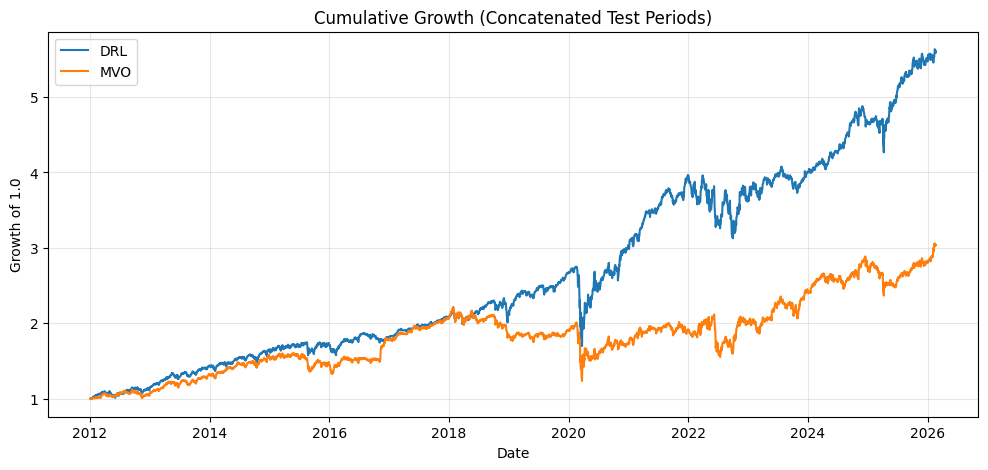

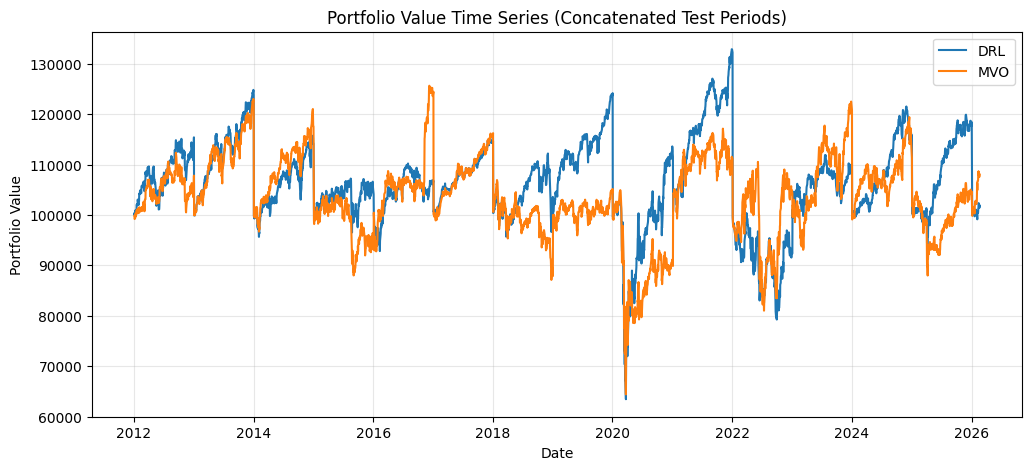

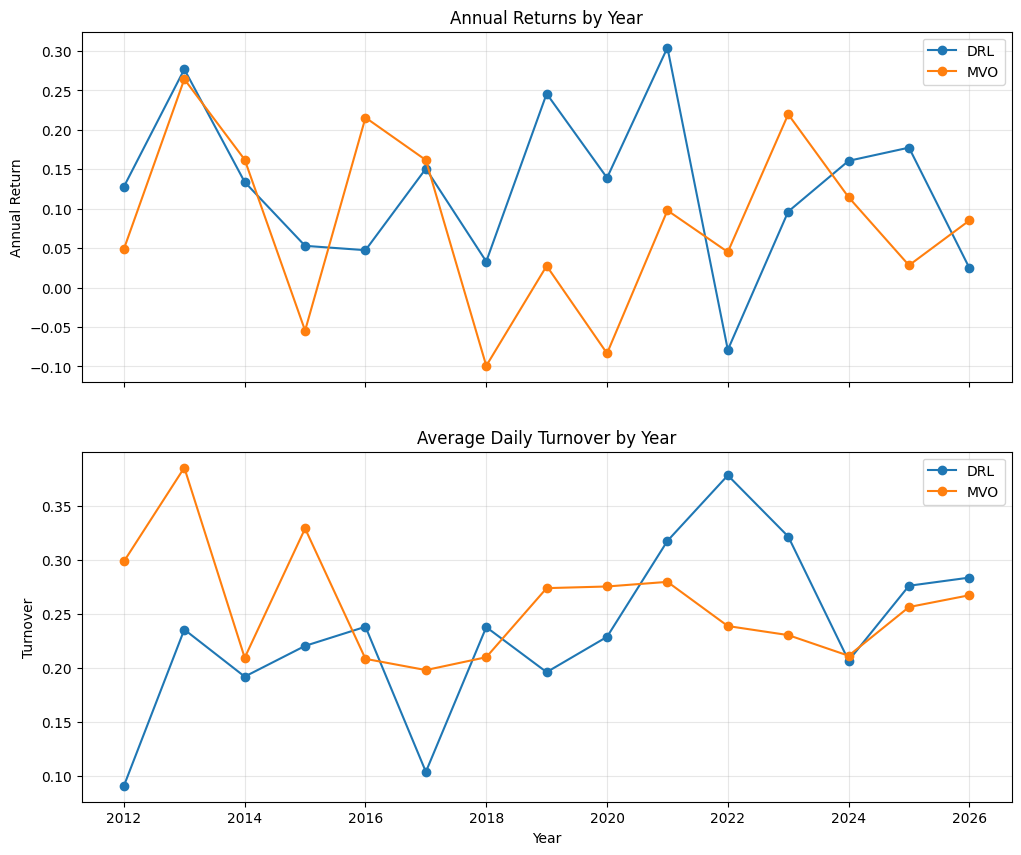

In [11]:
plot_df = backtest_records.copy()
plot_df['date_realized'] = pd.to_datetime(plot_df['date_realized'])
plot_df = plot_df.sort_values(['strategy', 'date_realized'])

fig_cumulative, ax = plt.subplots(figsize=(12, 5))
for strategy, g in plot_df.groupby('strategy'):
    g = g.sort_values('date_realized').copy()
    g['cum_growth'] = (1.0 + g['portfolio_return']).cumprod()
    ax.plot(g['date_realized'], g['cum_growth'], label=strategy)
ax.set_title('Cumulative Growth (Concatenated Test Periods)')
ax.set_xlabel('Date')
ax.set_ylabel('Growth of 1.0')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# 追加: ポートフォリオ価値の時系列推移（可視化のみ）
fig_value, ax = plt.subplots(figsize=(12, 5))
for strategy, g in plot_df.groupby('strategy'):
    g = g.sort_values('date_realized').copy()
    ax.plot(g['date_realized'], g['portfolio_value'], label=strategy)
ax.set_title('Portfolio Value Time Series (Concatenated Test Periods)')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

yearly_returns = (
    plot_df
    .assign(year=plot_df['date_realized'].dt.year)
    .groupby(['year', 'strategy'])['portfolio_return']
    .apply(lambda s: (1.0 + s).prod() - 1.0)
    .reset_index(name='annual_return')
)

yearly_turnover = (
    plot_df
    .assign(year=plot_df['date_realized'].dt.year)
    .groupby(['year', 'strategy'])['turnover']
    .mean()
    .reset_index(name='avg_turnover')
)

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
for strategy, g in yearly_returns.groupby('strategy'):
    axes[0].plot(g['year'], g['annual_return'], marker='o', label=strategy)
axes[0].set_title('Annual Returns by Year')
axes[0].set_ylabel('Annual Return')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

for strategy, g in yearly_turnover.groupby('strategy'):
    axes[1].plot(g['year'], g['avg_turnover'], marker='o', label=strategy)
axes[1].set_title('Average Daily Turnover by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Turnover')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
plt.show()


In [12]:
metrics_path = ARTIFACT_DIR / 'metrics_by_window.csv'
summary_path = ARTIFACT_DIR / 'summary_metrics.csv'
config_path = ARTIFACT_DIR / 'config_snapshot.json'
figure_path = ARTIFACT_DIR / 'cumulative_returns.png'

metrics_by_window.to_csv(metrics_path, index=False)
summary_metrics.to_csv(summary_path, index=False)

config_snapshot = {
    'generated_at': datetime.utcnow().isoformat() + 'Z',
    'config': CONFIG,
    'versions': VERSIONS,
    'data_source': data_source,
    'n_backtest_rows': int(len(backtest_records)),
}
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(config_snapshot, f, ensure_ascii=False, indent=2)

if 'fig_cumulative' in globals():
    fig_cumulative.savefig(figure_path, dpi=150, bbox_inches='tight')
else:
    plt.figure(figsize=(8, 4))
    plt.text(0.1, 0.5, 'cumulative plot not generated yet')
    plt.savefig(figure_path, dpi=150, bbox_inches='tight')
    plt.close()

for p in [metrics_path, summary_path, config_path, figure_path]:
    print(f'[saved] {p} -> {p.exists()}')


[saved] /Users/kencharoff/workspace/projects/rl/p02_deep_reinforcement_learning_for_optimal_portfolio_allocation/outputs/reproduction_artifacts/metrics_by_window.csv -> True
[saved] /Users/kencharoff/workspace/projects/rl/p02_deep_reinforcement_learning_for_optimal_portfolio_allocation/outputs/reproduction_artifacts/summary_metrics.csv -> True
[saved] /Users/kencharoff/workspace/projects/rl/p02_deep_reinforcement_learning_for_optimal_portfolio_allocation/outputs/reproduction_artifacts/config_snapshot.json -> True
[saved] /Users/kencharoff/workspace/projects/rl/p02_deep_reinforcement_learning_for_optimal_portfolio_allocation/outputs/reproduction_artifacts/cumulative_returns.png -> True


## 結果要約（記入ガイド）

- 本ノートは **論文フル相当の枠組み**（10本 walk-forward, DRL vs MVO）を維持しつつ、学習ステップを短縮した再現実装。  
- したがって、絶対的な数値一致ではなく、**比較傾向（Sharpe、年率リターン、回転率）** を重視して解釈する。  
- 実行後は `outputs/reproduction_artifacts/` の CSV / JSON / PNG を証跡として利用する。  
- MVOデバッグとして、`EfficientFrontier` 入力を `Series/DataFrame` に統一し、重みキーを ticker 名に一致させた。`window_run_log_df` の `mvo_error_summary` で失敗理由の内訳を確認できる。  
- 時系列図は「Portfolio Value Time Series」を参照。`date_realized` ベースで DRL/MVO のポートフォリオ価値推移を比較できる。  

### 再現限界
- 短縮 timesteps により論文と同等の収束までは保証しない。  
- データは ETF proxy を利用しており、論文の指数系列と完全一致しない。  
- 実行環境（CPU/GPU、有効なネット接続）で結果が変動する。
